## Housekeeping Settings

In [1]:
import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, logging, seaborn as sns, pickle
from scipy.stats import median_abs_deviation, hypergeom
import multiprocessing as mp, celloracle as co

# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/primaryBCell/'
out_path = os.path.join(wd, 'out_data', 'co_analysis')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/intermediate_data", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"

/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detai

## Reading the adata with scRNA and loading base GRN for ATAC part

In [2]:
path_to_adata = os.path.join(wd, 'out_data','sc_preproc/out_files/nick_sc_processed.h5ad')
adata = sc.read_h5ad(path_to_adata)
n_cells_downsample = 30000 # Random downsampling into 30K cells if the anndata object include more than 30 K cells.
if adata.shape[0] > n_cells_downsample:
    sc.pp.subsample(adata, n_obs=n_cells_downsample, random_state=123) # Downsample into 30K cells
# CO uses the unscaled mRNA count for the Input of Oracle object.
adata.X = adata.layers["counts"].A.copy()

In [4]:
# read MIRA data
with open(os.path.join(wd, 'out_data', 'out_other_methods/TF_dict_MIRA_95pct.pkl'),'rb') as f:
    TF_to_TG_dictionary = pickle.load(f)
hvf_genes_mira = set([tg for values_list in TF_to_TG_dictionary.values() for tg in values_list])
# read CICERO data
cicero_GRN = pd.read_csv(os.path.join(wd, 'out_data', 'out_other_methods/base_GRN_dataframe.csv'))
cicero_GRN = cicero_GRN[cicero_GRN['gene_short_name'].isin(hvf_genes_mira)].drop(columns=['peak_id']).groupby('gene_short_name').count().sort_values(by='gene_short_name',ascending=False)
TF_to_TG_dictionary.update({col: cicero_GRN.index[cicero_GRN[col] != 0].tolist() for col in cicero_GRN.columns if col not in TF_to_TG_dictionary.keys()})
with open(f'{out_path}/intermediate_data/TF_to_TG_dictionary.pkl','wb') as f:
    pickle.dump(TF_to_TG_dictionary, f)

In [6]:
import matplotlib.colors as mcolors
hex_codes = [mcolors.CSS4_COLORS[color] for color in adata.uns['leiden_colors']]# Convert color names to hex codes
adata.uns['leiden_colors'] = hex_codes

In [8]:
oracle = co.Oracle() # Instantiate Oracle object
oracle.import_anndata_as_raw_count(adata=adata, cluster_column_name="leiden", embedding_name="X_umap") # assigning scRNA (adata) to oracle object
TG_to_TF_dictionary = co.utility.inverse_dictionary(TF_to_TG_dictionary)
oracle.addTFinfo_dictionary(TG_to_TF_dictionary) # assigning scATAC (baseGRN) to oracle object

  0%|          | 0/2552 [00:00<?, ?it/s]

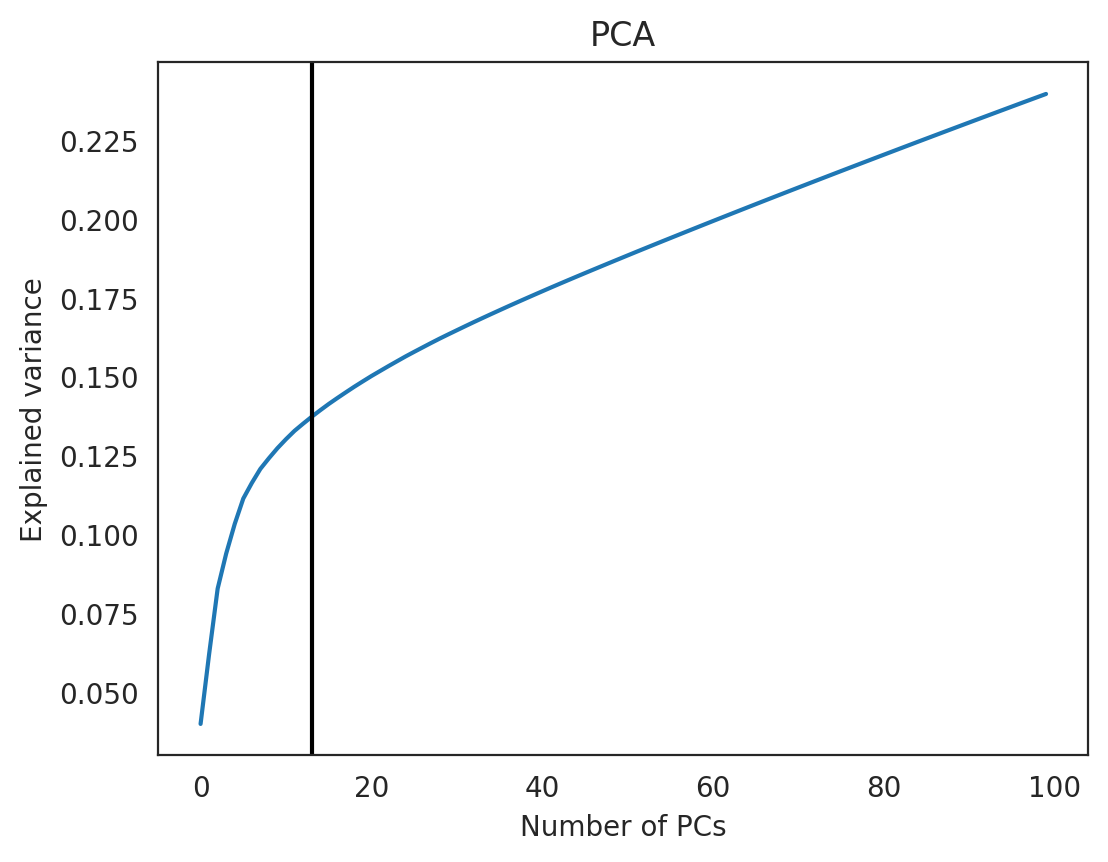

Optimal numbers of PCA dimensions are found to be : 13
Number of cell in the data are :30000
Auto-selected k is :750


In [9]:
## CellOracle uses the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.
# For the KNN imputation, we first need to calculate and select PCs. Perform PCA
oracle.perform_PCA()
# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k");plt.xlabel("Number of PCs");plt.ylabel("Explained variance");plt.title("PCA");plt.show()
print("Optimal numbers of PCA dimensions are found to be :",n_comps)
n_comps = min(n_comps, 50) ## Ceiling the number of PCs to 50

## Performing KNN imputation
n_cell = oracle.adata.shape[0]
print(f"Number of cell in the data are :{n_cell}")
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)
## Save cellOracle data
oracle.to_hdf5(f'{out_path}/intermediate_data/primaryBdata.celloracle.oracle')

## GRN Construction takes time, consider running batch script. Following cell creates `.sh`, `.py` scripts and submits it. 

In [2]:
import subprocess, os
def shell_script_header_cpu(save_path, job_name, n_cpu=16):
    sbatch_script_header_cpu = f"""#!/bin/bash
#SBATCH --job-name="{job_name}"
#SBATCH --output="{save_path}/scripts/{job_name}.log"
#SBATCH -p RM-shared
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task={n_cpu}
#SBATCH -t 0-01:30:00

module load anaconda3/2022.10
source activate celloracle_env

python {save_path}/scripts/{job_name}.py

"""
    return sbatch_script_header_cpu

#### Fit GRN for perturbation simulations

In [3]:
job_name = 'oracle_links_fitting'
py_file_script = f"""import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, logging, seaborn as sns, pickle
from scipy.stats import median_abs_deviation, hypergeom
import multiprocessing as mp, celloracle as co
wd = '{wd}'
out_path = os.path.join(f'{{wd}}', 'out_data', 'co_analysis')
oracle = co.load_hdf5(f'{{out_path}}/intermediate_data/primaryBdata.celloracle.oracle')
links = oracle.get_links(cluster_name_for_GRN_unit="leiden", alpha=10, verbose_level=10)
links.to_hdf5(f'{{out_path}}/intermediate_data/bayesian_fitted.celloracle.links')
# Calculate GRN for each population in clustering unit.
links.filter_links() # Getting back to default thresholds (p<0.001 and top 10k) for simulation of GRN -- so that we have enough edges to simulate the GRN
oracle.get_cluster_specific_TFdict_from_Links(links_object=links) #### Runs another round on links.filtered_links to get final links
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)
# Saving for KO simulation.
oracle.to_hdf5(f'{{out_path}}/intermediate_data/oracle_fitted.celloracle.oracle')
"""

with open(f'{wd}/scripts/{job_name}.sh', "w", encoding="utf-8") as f:
    f.write(shell_script_header_cpu(save_path = wd, job_name = job_name))
with open(f'{wd}/scripts/{job_name}.py', "w", encoding="utf-8") as f:
    f.write(py_file_script)
subprocess.run(["sbatch", f'{wd}/scripts/{job_name}.sh'])
print(f"Submitted {job_name}.sh")

Submitted batch job 26475748
Submitted oracle_links_fitting.sh


#### Do Perturbation after oracle and links object have been generated

In [5]:
job_name = 'oracle_tf_perturbation'
tf_of_interest = ['PRDM1']
py_file_script = f"""import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, logging, seaborn as sns, pickle
from scipy.stats import median_abs_deviation, hypergeom
import multiprocessing as mp, celloracle as co
wd = '{wd}'
out_path = os.path.join(f'{{wd}}', 'out_data', 'co_analysis')
oracle = co.load_hdf5(f'{{out_path}}/intermediate_data/oracle_fitted.celloracle.oracle')

def ko_simulation(oracle,goi, cluster_column_name="cell_type"):
    try:
        # Enter perturbation conditions to simulate signal propagation after the perturbation.
        print(f'Simulating perturbation for {{goi}}')
        oracle.simulate_shift(perturb_condition={{goi: 0.0}},n_propagation=2) # If kernal crashes increase the memory limit of jupyter notebook
        print(f'Estimating transition probability for {{goi}}')
        oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1) # Get transition probability
        print(f'Calculating embedding for {{goi}}')
        oracle.calculate_embedding_shift(sigma_corr=0.05) # Calculate embedding
        print(f'Saving perturbed data for {{goi}}')
        oracle.to_hdf5(f'{{out_path}}/out_files/{{goi}}_perturbation.celloracle.oracle')
    except Exception as e:
        print(f'Process {{mp.current_process().name}} failed for gene {{goi}} with error {{e}}', flush=True)
    return None

with mp.Pool(processes=os.cpu_count()) as pool:
    tf_of_interest = {tf_of_interest}
    tasks = [pool.apply_async(ko_simulation, args=(oracle, tf)) for tf in tf_of_interest]
    for task in tasks:
        try:
            result = task.get()  # Specify timeout according to needs
            print(f'Task completed: {{task}}')
        except Exception as e:
            print(f'Task failed: {{e}}')
"""
with open(f'{wd}/scripts/{job_name}.sh', "w", encoding="utf-8") as f:
    f.write(shell_script_header_cpu(save_path = wd, job_name = job_name, n_cpu=64))
with open(f'{wd}/scripts/{job_name}.py', "w", encoding="utf-8") as f:
    f.write(py_file_script)
subprocess.run(["sbatch", f'{wd}/scripts/{job_name}.sh'])
print(f"Submitted {job_name}.sh")

Submitted batch job 26476671
Submitted oracle_tf_perturbation.sh


In [ ]:
# # If you want to run in the notebook, you can run the following code. Bad idea though.

#### Fit GRN for perturbation simulations
# import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, logging, seaborn as sns, pickle
# from scipy.stats import median_abs_deviation, hypergeom
# import multiprocessing as mp, celloracle as co

# out_path = os.path.join(f'{save_path}', 'out_data', 'co_analysis')
# oracle = co.load_hdf5(f'{out_path}/intermediate_data/sc_mc.celloracle.oracle')
# links = oracle.get_links(cluster_name_for_GRN_unit="leiden", alpha=10, verbose_level=10)
# # Calculate GRN for each population in clustering unit.
# links.filter_links() # Getting back to default thresholds (p<0.001 and top 10k) for simulation of GRN -- so that we have enough edges to simulate the GRN
# oracle.get_cluster_specific_TFdict_from_Links(links_object=links) #### Runs another round on links.filtered_links to get final links
# oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)
# # Saving for KO simulation.
# oracle.to_hdf5(f'{out_path}/intermediate_data/oracle_fitted.celloracle.oracle')
# links.to_hdf5(f'{out_path}/intermediate_data/oracle_fitted.celloracle.links')

#### Do Perturbation after oracle and links object have been generated
# def ko_simulation(oracle,goi, cluster_column_name="cell_type"):
#     try:
#         # Enter perturbation conditions to simulate signal propagation after the perturbation.
#         print(f'Simulating perturbation for {{goi}}')
#         oracle.simulate_shift(perturb_condition={{goi: 0.0}},n_propagation=2) # If kernal crashes increase the memory limit of jupyter notebook
#         print(f'Estimating transition probability for {{goi}}')
#         oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1) # Get transition probability
#         print(f'Calculating embedding for {{goi}}')
#         oracle.calculate_embedding_shift(sigma_corr=0.05) # Calculate embedding
#         print(f'Saving perturbed data for {{goi}}')
#         oracle.to_hdf5(f'{{out_path}}/{{goi}}_perturbation.celloracle.oracle')
#     except Exception as e:
#         print(f'Process {{mp.current_process().name}} failed for gene {{goi}} with error {{e}}', flush=True)
#     return None

# with mp.Pool(processes=os.cpu_count()) as pool:
#     tf_of_interest = ['BATF', 'IRF4', 'IRF8', 'PRDM1', 'SPIB']
#     tasks = [pool.apply_async(ko_simulation, args=(oracle, tf)) for tf in tf_of_interest]
#     for task in tasks:
#         try:
#             result = task.get()  # Specify timeout according to needs
#             print(f'Task completed: {{task}}')
#         except Exception as e:
#             print(f'Task failed: {{e}}')

# For Network Analysis creating and saving final network!

In [26]:
# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

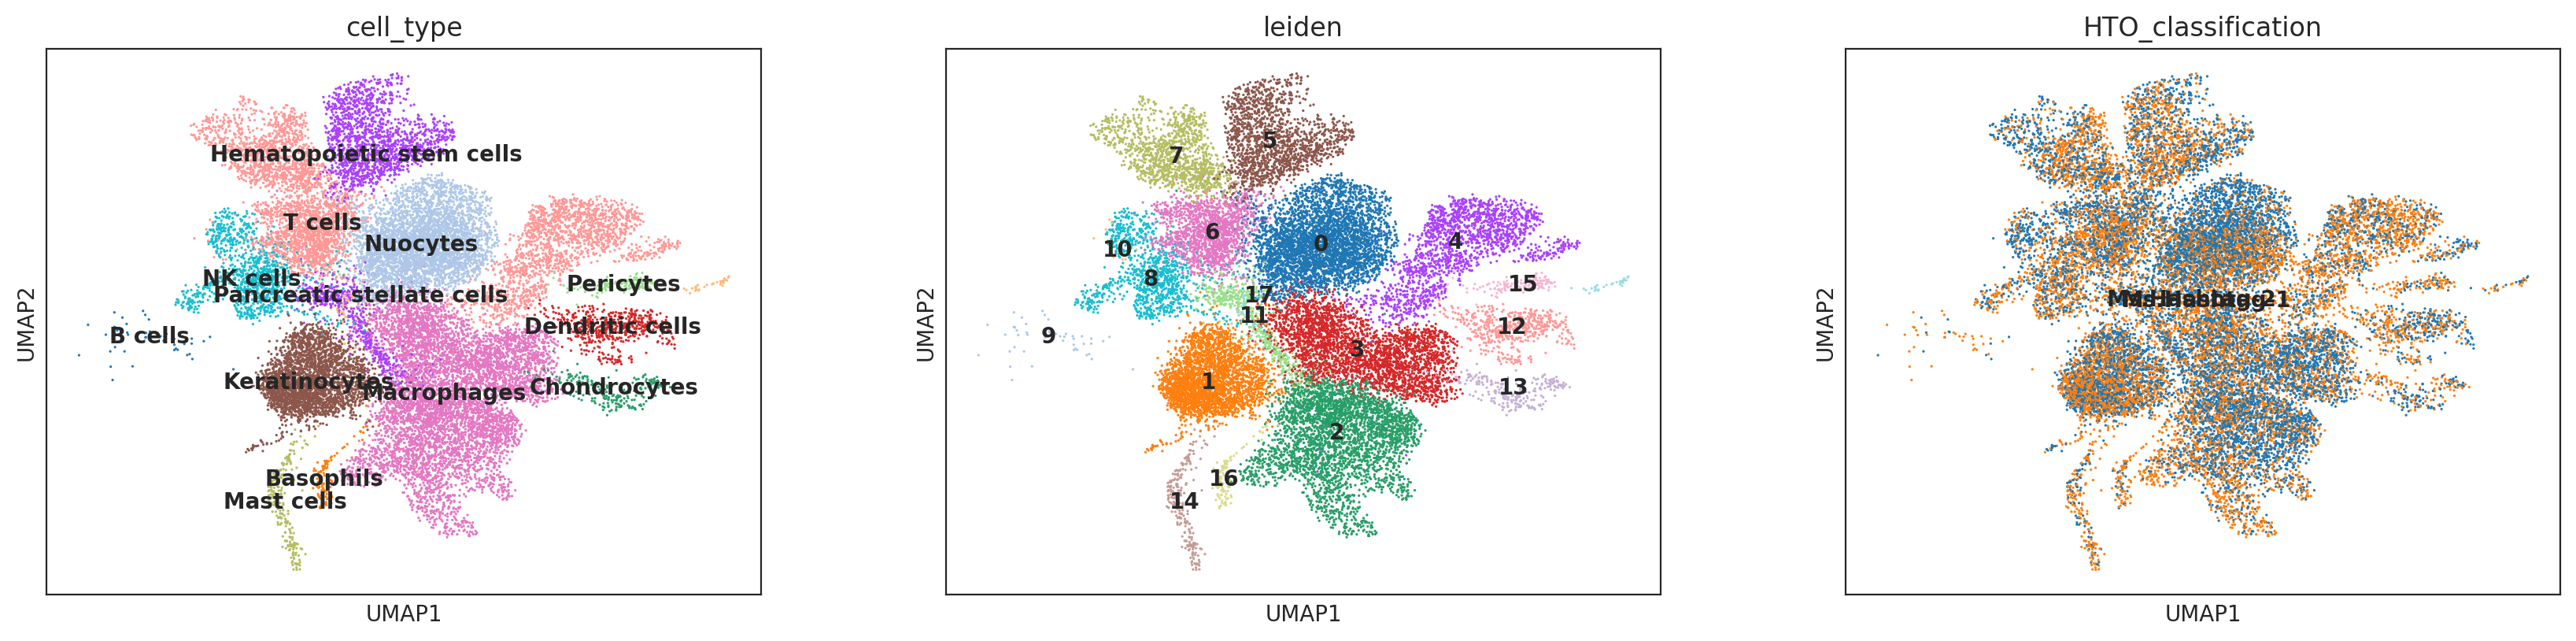

In [29]:
oracle = co.load_hdf5(f'{out_path}/intermediate_data/oracle_fitted.celloracle.oracle')
sc.pl.umap(oracle.adata, color=['cell_type', 'leiden', 'HTO_classification'], legend_loc='on data', save="_umap_cell_type_auto_co.png")

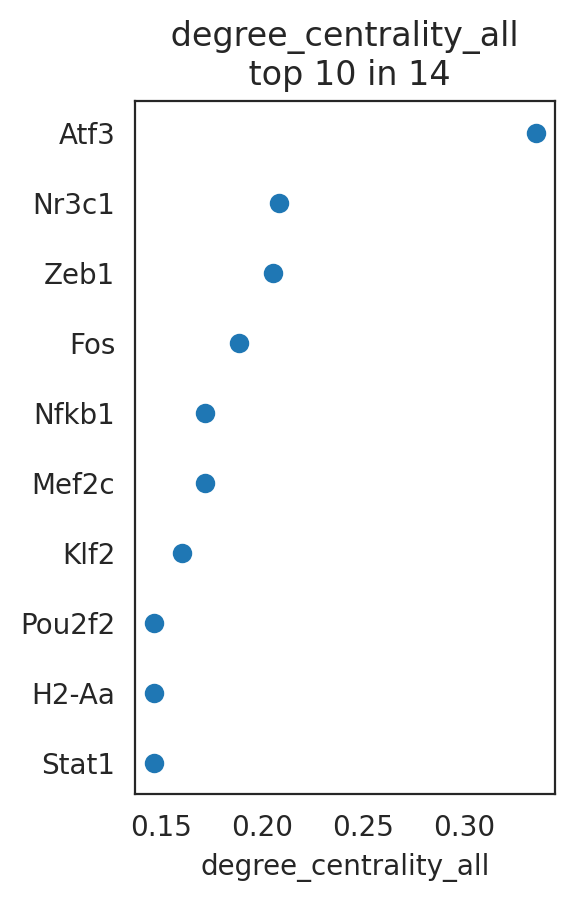

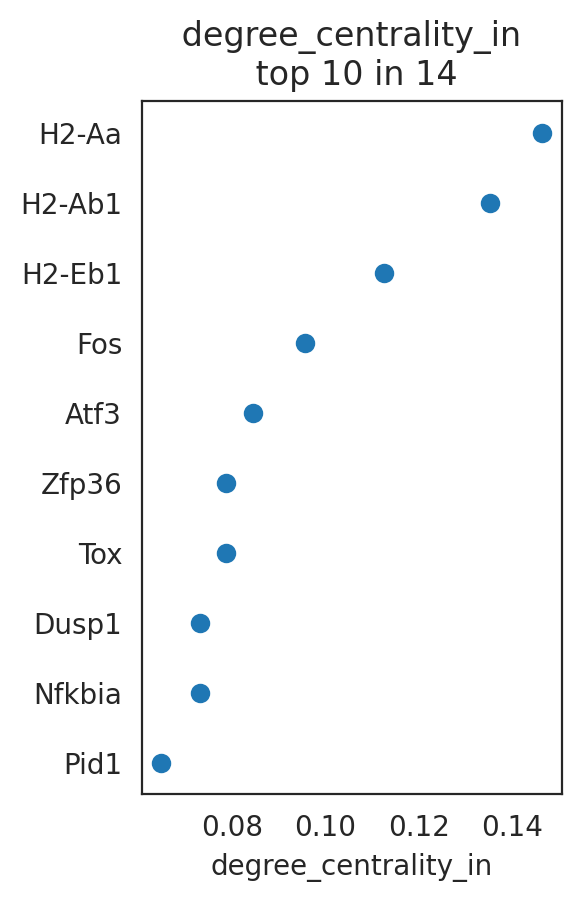

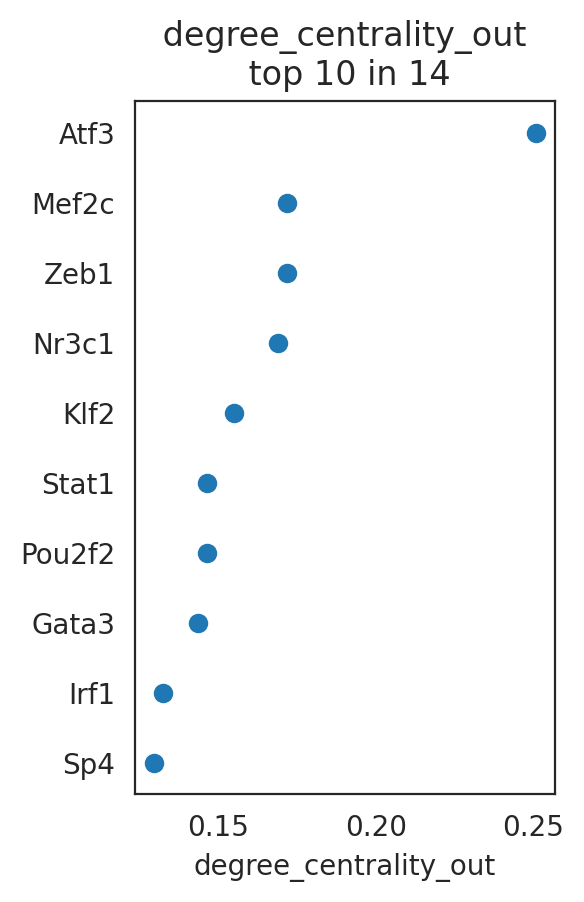

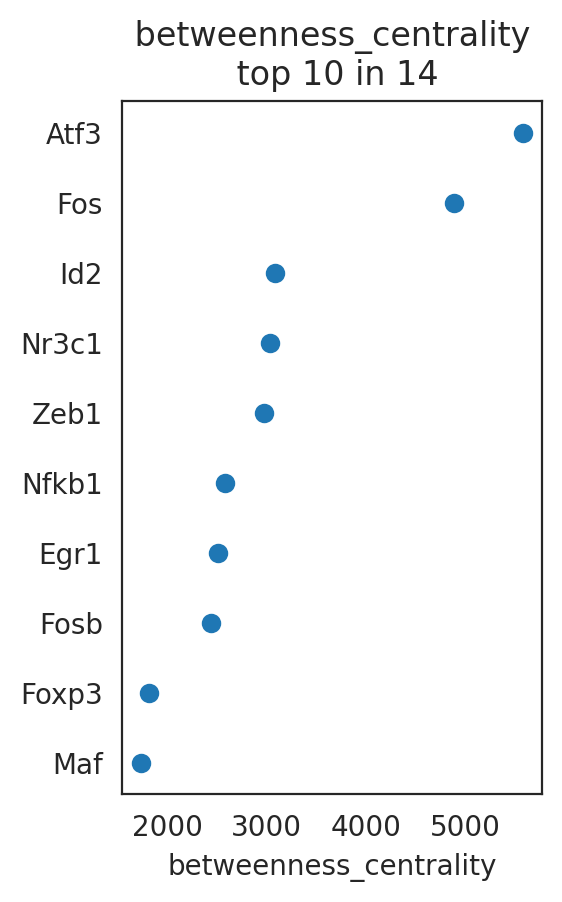

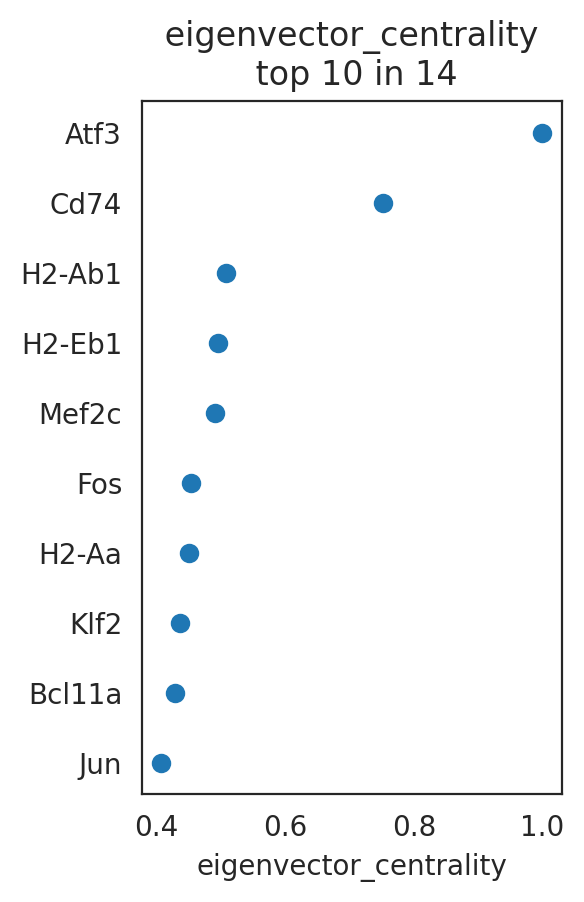

In [18]:
links = co.load_hdf5(f'{out_path}/intermediate_data/bayesian_fitted.celloracle.links')
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
links.get_network_score()
links.plot_scores_as_rank(cluster="14", n_gene=10)

2024-10-16 10:56:26,497 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-16 10:56:26,507 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


degree_centrality_all


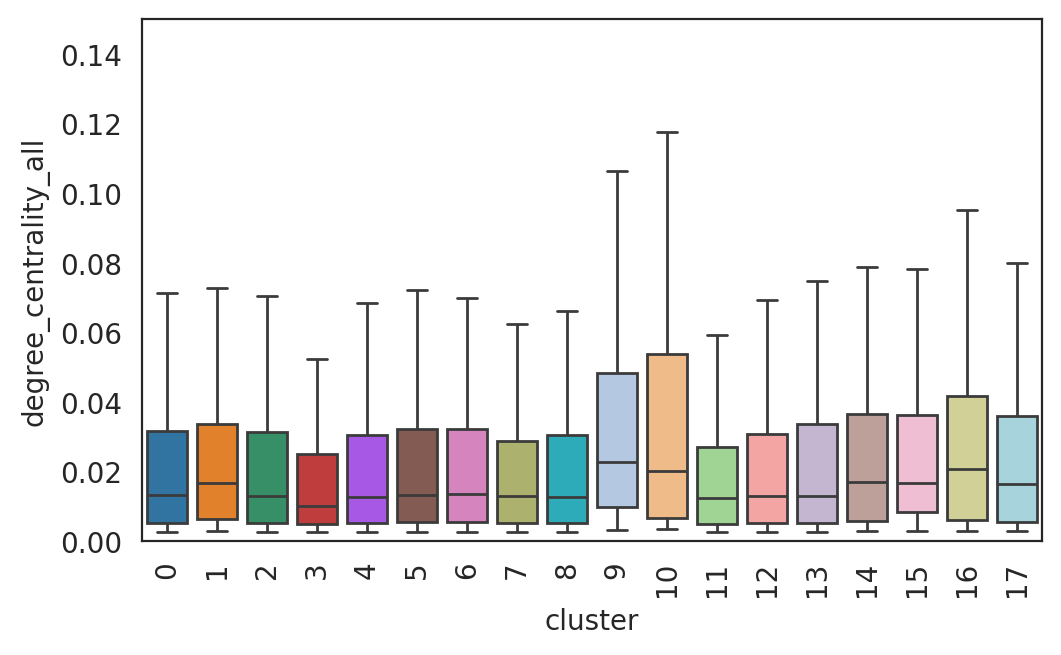

2024-10-16 10:56:26,857 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-16 10:56:26,866 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


eigenvector_centrality


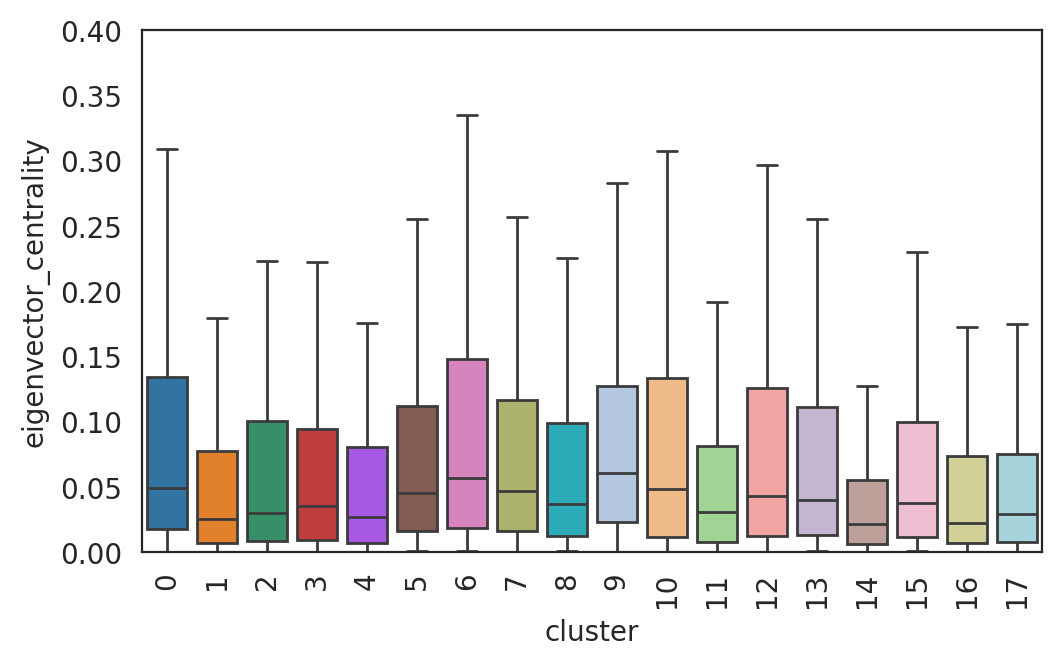

In [33]:
plt.rcParams["figure.figsize"] = [6, 4.5]
# Plot degree_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.15])
links.plot_score_discributions(values=["degree_centrality_all"], method="boxplot")
# Plot eigenvector_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.4])
links.plot_score_discributions(values=["eigenvector_centrality"],method="boxplot")

In [19]:
links_after_fit = co.Links(name="links_after_fit")
links_after_fit.links_dict = links.links_dict #### Saving (GRN 1 simulation) completely
links_after_fit.filtered_links = links.filtered_links #### Just for initialization

for cluster in links.filtered_links.keys():
    cluster_specific_links = oracle.coef_matrix_per_cluster[cluster].stack().reset_index()
    cluster_specific_links.columns = ['source', 'target', 'coef_mean']
    cluster_specific_links = cluster_specific_links[cluster_specific_links ['coef_mean'] != 0].reset_index(drop=True)
    cluster_specific_links['coef_abs'] = np.abs(cluster_specific_links['coef_mean'])
    cluster_specific_links.to_csv(f'{out_path}/intermediate_data/cluster_{cluster}.csv', index=False)
    links_after_fit.filtered_links[cluster] = cluster_specific_links

links_after_fit.get_network_score()
links_after_fit.merged_score.to_csv(f'{out_path}/intermediate_data/network_analysis_scores.csv')
links.to_hdf5(f'{out_path}/intermediate_data/oracle_fitted.celloracle.links')

In [ ]:
# For network scores filter to the top 2000 edges and only significant edges...because they most likely will be in the network
# Remove uncertain network edges based on the p-value.
# Remove weak network edge. In this tutorial, we keep the top 2000 edges ranked by edge strength.
# The raw network data is stored in the `links_dict` attribute, while the filtered network data is stored in the `filtered_links` attribute. 
# links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
# links.get_network_score()
# links.to_hdf5(os.path.join(wd, '../out_data/intermediate_data', "network_analysis.celloracle.links"))
# links.merged_score.to_csv(os.path.join(wd, '../out_data/intermediate_data', "network_analysis_scores.csv"))
# color_dict = {str(k): v for k, v in zip(set(oracle.adata.obs['leiden'].astype(int)), ['lightskyblue', 'dodgerblue', 'mediumorchid', 'limegreen', 'darkblue', 'darkgray', 'green', 'firebrick', 'sandybrown', 'lightcoral', 'teal', 'gold'])}
# oracle.colorandum = np.array([color_dict[i] for i in oracle.adata.obs['leiden']])    

In [58]:
links_after_fit = co.Links(name="links_after_fit")
links_after_fit.filtered_links = links.filtered_links #### Just for initialization

for cluster in links.filtered_links.keys():
    cluster_specific_links = oracle.coef_matrix_per_cluster[cluster].stack().reset_index()
    cluster_specific_links.columns = ['source', 'target', 'coef_mean']
    cluster_specific_links = cluster_specific_links[cluster_specific_links ['coef_mean'] != 0].reset_index(drop=True)
    cluster_specific_links['coef_abs'] = np.abs(cluster_specific_links['coef_mean'])
    cluster_specific_links.to_csv(f'{out_path}/intermediate_data/cluster_{cluster}.csv', index=False)
    links_after_fit.filtered_links[cluster] = cluster_specific_links

In [62]:
links.filtered_links['0'].head()

source  target  coef_mean  coef_abs
0  Mybl1    Aspm   0.005015  0.005015
1  Mybl1   Itgav  -0.014478  0.014478
2  Mybl1  Nusap1   0.005479  0.005479
3  Mybl1   Frmd5   0.004947  0.004947
4  Mybl1   Ube2c   0.008272  0.008272

In [61]:
links_after_fit.filtered_links['0'].head()

source  target  coef_mean  coef_abs
0  Mybl1    Aspm   0.005015  0.005015
1  Mybl1   Itgav  -0.014478  0.014478
2  Mybl1  Nusap1   0.005479  0.005479
3  Mybl1   Frmd5   0.004947  0.004947
4  Mybl1   Ube2c   0.008272  0.008272

## Perturbation analysis and figure generation

In [6]:
goi = 'Stat1'
oracle = co.load_hdf5(f'{out_path}/out_files/{goi}_perturbation.celloracle.oracle')

<AxesSubplot: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

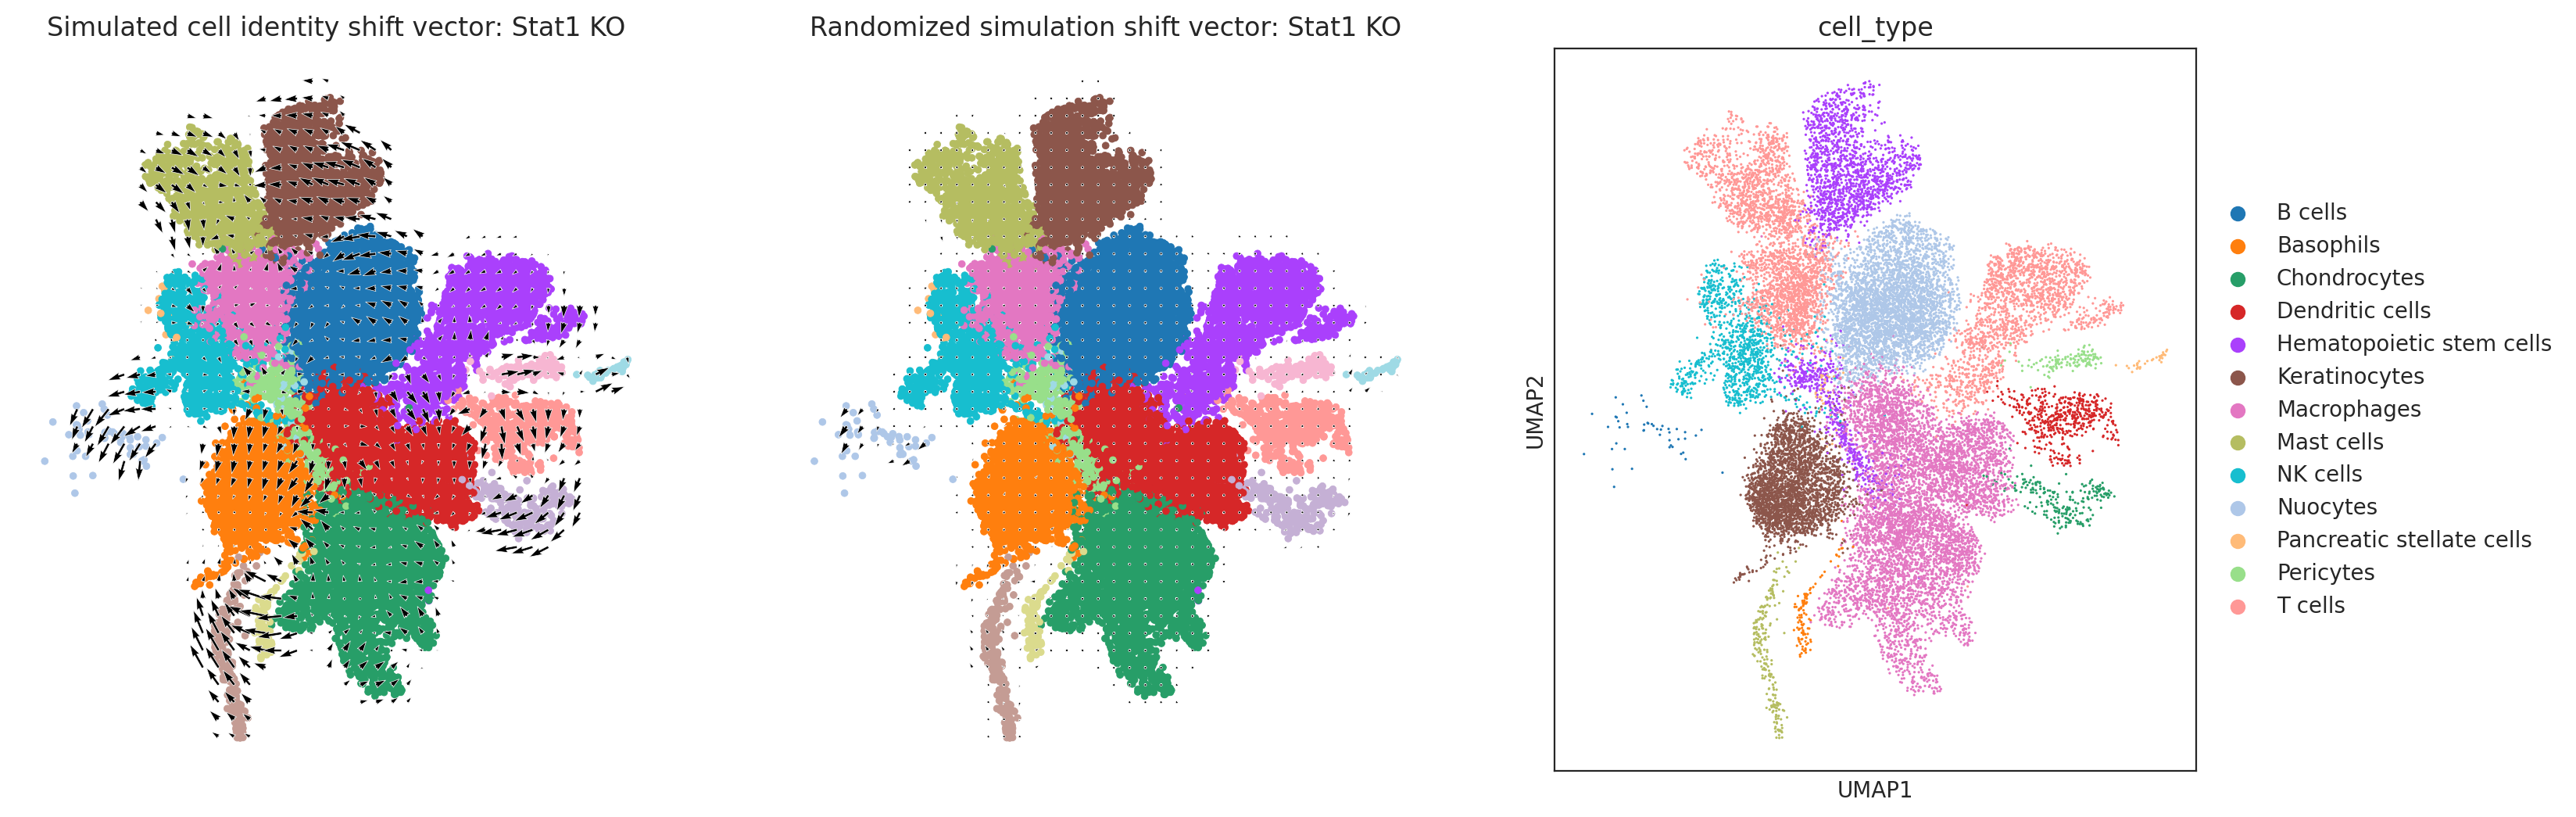

In [7]:
fig, ax = plt.subplots(1, 3,  figsize=[18, 6])
n_grid = 40; min_mass = 3; scale_simulation = 15
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
oracle.calculate_mass_filter(min_mass=min_mass, plot=False)
oracle.plot_cluster_whole(ax=ax[0], s=10)
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0], show_background=False)
oracle.plot_cluster_whole(ax=ax[1], s=10)
ax[1].set_title(f"Randomized simulation shift vector: {goi} KO")
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1], show_background=False)
ax[2].set_title(f"Clustered cell identity")  
sc.pl.umap(oracle.adata, color=['cell_type'], ax=ax[2], show=False)

## Frequency enrichment of cells

In [ ]:
def perturb_in_out(goi):
    result = {goi: []}
    print(f"Calculating ratio for {goi}", flush=True)
    oracle = co.load_hdf5(os.path.join(wd, '../out_data/intermediate_data', f"{goi}_perturbation.celloracle.oracle"))

    # Plotting the perturbation graph
    n_grid = 40; min_mass = 0.04
    oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
    oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

    fig, ax = plt.subplots(figsize=[8, 8])
    scale_simulation = 15
    oracle.plot_cluster_whole(ax=ax, s=10)
    oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)
    plt.title(f"{goi} KO simulation")
    plt.savefig(f'{out_path}/figures/{goi}_KO_simulation.svg', dpi=600, format="svg")
    plt.close()

    fig, ax = plt.subplots(figsize=[8, 8])
    scale_simulation = 15
    oracle.plot_cluster_whole(ax=ax, s=10)
    oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax, show_background=False)
    plt.title(f"{goi} KO random simulation")
    plt.savefig(f'{out_path}/figures/{goi}_KO_random_simulation.svg', dpi=600, format="svg")
    plt.close()

    # Defining the type of TF which a TF is
    gc_mean = np.mean(oracle.adata.X[(oracle.adata.obs['cell_type'] == 'GC'),(oracle.adata.var_names == goi)].A)
    pb_mean = np.mean(oracle.adata.X[(oracle.adata.obs['cell_type'] == 'PB'),(oracle.adata.var_names == goi)].A)
    if gc_mean > pb_mean:
        TF_type = 'GC'
    else:
        TF_type = 'PB'
    
    totalGC_counts = oracle.adata.obs[(oracle.adata.obs['cell_type'] == 'GC')].shape[0]
    totalPB_counts = oracle.adata.obs[(oracle.adata.obs['cell_type'] == 'PB')].shape[0]
    total34_counts = oracle.adata.obs[(oracle.adata.obs['cell_type'] == 'Day3_4')].shape[0]

    transition_matrix = oracle.transition_prob
    # transition_matrix = oracle.transition_prob - (oracle.embedding_knn.A/ oracle.embedding_knn.sum(1).A.T)
    transition_matrix = abs(transition_matrix[oracle.adata.obs['cell_type'].isin(['GC', 'PB', 'Day3_4']),:])
    row_labels = oracle.adata.obs[oracle.adata.obs['cell_type'].isin(['GC', 'PB', 'Day3_4'])]['cell_type'].values
    col_labels = oracle.adata.obs['cell_type'].values
    tm_df = pd.DataFrame(transition_matrix, index=row_labels, columns=col_labels)

    # Cell transition is based on Max probability
    max_prob = tm_df.idxmax(axis=1).reset_index()
    max_prob = max_prob[max_prob['index']!=max_prob[0]].groupby('index').agg(lambda x: x.value_counts().to_dict())
    gc_in = 0
    try:
        gc_in += max_prob.loc['Day3_4'][0]['GC']
    except KeyError:
        pass
    
    try:
        gc_in += max_prob.loc['PB'][0]['GC']
    except KeyError:
        pass

    pb_in = 0
    try:
        pb_in += max_prob.loc['Day3_4'][0]['PB']
    except KeyError:
        pass

    try:
        pb_in += max_prob.loc['GC'][0]['PB']
    except KeyError:
        pass
    
    try:
        gc_out = 0 + sum(list(max_prob.loc['GC'][0].values()))
    except KeyError:
        gc_out = 0
    
    try:
        pb_out = 0 + sum(list(max_prob.loc['PB'][0].values()))
    except KeyError:
        pb_out = 0

    finalGC_counts = totalGC_counts - gc_out + gc_in
    finalPB_counts = totalPB_counts - pb_out + pb_in
    result[goi] = [TF_type, totalGC_counts, totalPB_counts, total34_counts, finalGC_counts, finalPB_counts,gc_in, pb_in, gc_out, pb_out]
    return result

In [ ]:
with open(os.path.join(wd, '../out_data/intermediate_data', 'ratio_enrichment.pkl'),'rb') as f:
    ratio = pickle.load(f)
combined_dict = {}
for d in ratio:
    combined_dict.update(d)

x,y = [],[]
colors=[]
for tf in combined_dict.keys():
    x.append(tf)
    # y.append(np.log2(((combined_dict[tf][1]-combined_dict[tf][i+3])/(combined_dict[tf][2]-combined_dict[tf][i+4]))/(combined_dict[tf][1]/combined_dict[tf][2])))
    y.append(np.log2(((combined_dict[tf][4]/combined_dict[tf][5])/(combined_dict[tf][1]/combined_dict[tf][2]))))
    colors.append('r' if combined_dict[tf][0] == 'GC' else 'b')
    pd.DataFrame({'TF':x, 'Ratio':y}).to_csv(os.path.join(wd, '../out_data/perturbed_data', f'ratio_enrichment_model.csv'))

plt.figure(figsize=(20,5))
plt.title('Enrichment Ratios')
sns.barplot(x=x, y=y, palette=colors)
plt.hlines(y=0.01, xmin=0, xmax=len(x)-1, colors='k', linestyles='dashed')
plt.hlines(y=0.00, xmin=0, xmax=len(x)-1, colors='k')
plt.hlines(y=-0.01, xmin=0, xmax=len(x)-1, colors='k', linestyles='dashed')
plt.ylabel('Final Ratio (GC/PB)/Initial Ratio(GC/PB)')
plt.savefig(os.path.join(wd, '../out_data/perturbed_data', f'ratio_enrichment_model.png'))

# SLIDE TF Enrichment

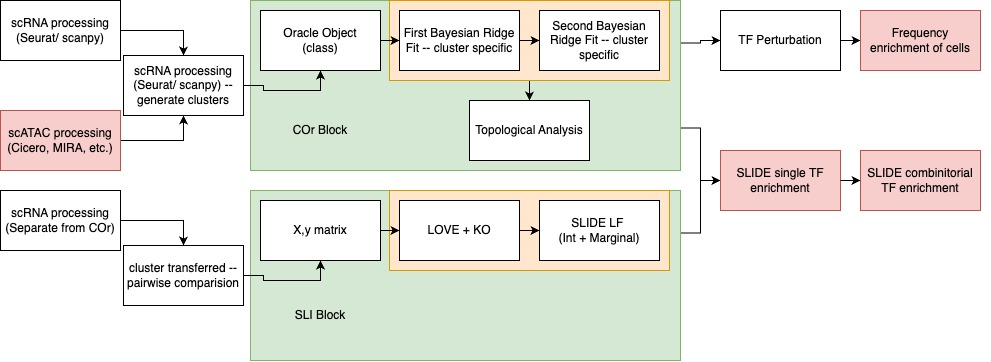

In [29]:
links = co.load_hdf5(f'{out_path}/intermediate_data/bayesian_fitted.celloracle.links')
links.filter_links()
def lf_gene_list(CO_TFs, list_of_paths_to_lfs):
    LF_genes=[]
    for path in list_of_paths_to_lfs:
        if type(path) == str:
            LF_genes=LF_genes+list(pd.read_csv(path,sep='\t')['names'])
    slide_TFs = set(LF_genes).intersection(CO_TFs)
    slide_genes = set(LF_genes).difference(CO_TFs)
    return slide_TFs,slide_genes

CO_TFs = []
for cluster in links.filtered_links.keys():
    links.filtered_links[cluster]['weight'] = links.filtered_links[cluster]['coef_abs'] * links.filtered_links[cluster]['-logp']
    CO_TFs = CO_TFs + list(links.filtered_links[cluster].source.unique())

CO_TFs = set(CO_TFs)
list_of_LFs = pd.read_csv(f"{wd}/out_data/out_other_methods/slide_results/LFs.txt",sep='\t')
slide_sa_TFs,slide_sa_genes = lf_gene_list(CO_TFs, list(list_of_LFs['Sig_LFs']))
slide_int_TFs,slide_int_genes = lf_gene_list(CO_TFs, list(list_of_LFs['Interacting_LFs']))
slide_TF = list(slide_sa_TFs.union(slide_int_TFs))
slide_genes = list(slide_sa_genes.union(slide_int_genes))

In [31]:
from functools import reduce
from collections import Counter
clstr_fr_pairwise_comp = ['14','14']
if clstr_fr_pairwise_comp is None:
    clstr_fr_pairwise_comp = list(links.filtered_links.keys())
cluster_pairs = list(itertools.combinations(clstr_fr_pairwise_comp, 2))

min_weight_threshold = 0.5

def classify_weights(weights, threshold):
    strong = 0
    weak = 0
    for weight in weights:
        if weight > threshold:
            strong += 1
        else:
            weak += 1
    return [weak, strong]

def enrichment(M,n,N,X):
    # M is the total number of items in the population ===> Total starting genes in SLIDE
    # n is the number of successes in the population ===> Downstream genes
    # N is the sample size ===> Total SLIDE genes in LF
    # X is the number of successes in the sample.
    p_value = 1 - hypergeom.cdf(X-1, M, n, N)   # Compute the p-value for observing X or more successes
    score = math.log2((X/n)/(N/M))
    return (score, p_value)

def LF_enrichment(cc_dict, cluster_pair, comb_tfs, clst_pair_graph, total_source, total_target):
    TF_permut = list(itertools.combinations(total_source, comb_tfs))
    conditions_of_interest = list(itertools.product([0, 1], repeat=comb_tfs))
    cc_dict.setdefault(cluster_pair, {}).setdefault(str(comb_tfs), [])
    for TF_comb in TF_permut:
        if set(TF_comb).issubset(set(clst_pair_graph.nodes)):
            for condition in conditions_of_interest:
                common, dwngene = 0, 0
                cmn_list, dwn_list = [], []
                common_targets_from_grn = reduce(set.intersection, map(lambda TF: set(clst_pair_graph[TF].keys()), TF_comb))
                for target in common_targets_from_grn:
                    if all(clst_pair_graph[TF][target].get('weight', None)[cond] > 0 for TF, cond in zip(TF_comb, condition)): # abs value of edge weight should not be zero
                        dwngene+=1; dwn_list.append(target)
                        if target in total_target: 
                            common+=1; cmn_list.append(target) # enriched in SLIDE LF, increase common
                
                if dwngene==0 or common==0:
                    cc_dict[cluster_pair][str(comb_tfs)].append([TF_comb, (condition), (0,1), (cmn_list, dwn_list)])
                else:
                    cc_dict[cluster_pair][str(comb_tfs)].append([TF_comb, (condition), enrichment(M,dwngene,len(total_target),common), (cmn_list, dwn_list)])
    return cc_dict

cc_dict = {}
M = 6700
for cluster_pair in cluster_pairs:
    combined_links = pd.concat([links.filtered_links[cluster_pair[0]], links.filtered_links[cluster_pair[1]]]).sort_values(by='weight', ascending=False)
    # Creating the network
    combined_links['sorted_source'] = combined_links[['source', 'target']].min(axis=1)
    combined_links['sorted_target'] = combined_links[['source', 'target']].max(axis=1)
    # Classifying the weights
    grouped_df = combined_links.groupby(['sorted_source', 'sorted_target'])['weight'].apply(lambda x: classify_weights(x, min_weight_threshold)).reset_index()
    clst_pair_graph = nx.from_pandas_edgelist(grouped_df, source='sorted_source', target='sorted_target',edge_attr='weight').to_undirected()
    # Integrating SLIDE
    slide_genes_TF = list(combined_links[combined_links['target'].isin(slide_genes)]['source'].unique())
    total_source = set(slide_TF).union(set(slide_genes_TF))
    total_target = set(slide_TF).union(set(slide_genes))
    for comb_tfs in range(1, 3):
        cc_dict = LF_enrichment(cc_dict, cluster_pair, comb_tfs, clst_pair_graph, total_source, total_target)

In [38]:
cc_dict

{('14',
  '14'): {'1': [[('Tal1',),
    (0,),
    (2.9410259242086383, 1.9013028856873504e-06),
    (['Slc18a2',
      'Slc29a1',
      'Serpinb1a',
      'Gnai1',
      'Cd63',
      'Clec10a',
      'Egr1',
      'Chst1',
      'Kit'],
     ['Sgcd',
      'Agap1',
      'Slc18a2',
      'Cdk6',
      'Dusp1',
      'Pde4d',
      'Tnfaip3',
      'Nkg7',
      'Il18r1',
      'Maml2',
      'Nr4a1',
      'Ctla2a',
      'Ctsc',
      'Gab2',
      'Lsamp',
      'Slc29a1',
      'Hs6st2',
      'Il2rb',
      'Serpinb1a',
      'Tox',
      'Lgals3',
      'Gata2',
      'Itgae',
      'Ctss',
      'Hsph1',
      'Pid1',
      'Cd86',
      'Alox5ap',
      'Fosb',
      'Kcnq5',
      'St6galnac3',
      'Tgfbi',
      'Gnai1',
      'Dnajb1',
      'Mpp7',
      'Prkcb',
      'Mafb',
      'Marcks',
      'Ccnd2',
      'Hdc',
      'Cd63',
      'Kif13b',
      'Arid5b',
      'Clec10a',
      'Rgs2',
      'Cd209a',
      'Inpp4b',
      'Fcer1g',
      'Egr1',
      'Chst1',


In [50]:
enrichment_df = pd.DataFrame(cc_dict[cluster_pair]['1'], columns=['TF', 'Condition', 'ES', 'Genes'])
enrichment_df_split = enrichment_df['ES'].apply(pd.Series)
enrichment_df_split.columns = ['Score', 'p_value']
enrichment_df = pd.concat([enrichment_df.drop(columns=['ES']), enrichment_df_split], axis=1)
enrichment_df_split = enrichment_df['Genes'].apply(pd.Series)
enrichment_df_split.columns = ['common', 'dwnstrm']
enrichment_df = pd.concat([enrichment_df.drop(columns=['Genes']), enrichment_df_split], axis=1)
filter_enrichment_df = ((enrichment_df['Condition']==(1,)) | (enrichment_df['Condition']==(1,))) & (enrichment_df['p_value']<0.05) \
                        & (enrichment_df['dwnstrm'].apply(len)>1) & (enrichment_df['common'].apply(len)>1) & (enrichment_df['Score']>0)
enrichment_df = enrichment_df[filter_enrichment_df]

In [51]:
enrichment_df

TF Condition     Score   p_value                   common  \
103   (Klf2,)      (1,)  2.771101  0.033446          [Nfkbia, Zfp36]   
111  (Nr3c1,)      (1,)  2.771101  0.033446         [Tyrobp, Gpr183]   
157   (Atf3,)      (1,)  1.847050  0.049910   [Clec10a, Ccl4, Zfp36]   
163    (Ehf,)      (1,)  3.301616  0.016372           [Tyrobp, Ccl9]   
175    (Fos,)      (1,)  2.471541  0.049248            [Zfp36, Egr1]   
189   (Egr1,)      (1,)  3.734575  0.001199  [Nfkbia, Tyrobp, Zfp36]   

                                               dwnstrm  
103  [Nfkbia, Dusp1, Cd74, Cst3, Zfp36, Psap, Zeb2,...  
111  [Itk, Il1b, Il18r1, Tyrobp, Lyz2, Maml2, Il7r,...  
157  [Ms4a6c, Mef2c, Apod, Bcl11a, Clec10a, Il1b, C...  
163  [Clec4a2, Tyrobp, Lgals3, Lyz2, Zeb2, H2-Eb1, ...  
175  [Fosb, Il1b, Dusp1, Cst3, Zfp36, Zbtb7c, Jun, ...  
189  [Fosb, Nfkbia, Dusp1, Hspa1b, Cd74, Tyrobp, Zf...

In [ ]:
plot_df = enrichment_df.groupby('TF').agg({'Score': 'mean', 'common' : lambda x: len(set().union(*x)), 'dwnstrm' : lambda x: len(set().union(*x))}).reset_index()
plot_df_split = plot_df['TF'].apply(pd.Series)
plot_df_split.columns = ['TF1', 'TF2']
plot_df = pd.concat([plot_df.drop(columns=['TF']), plot_df_split], axis=1)
plot_df ['TF1_c'] = plot_df['TF1'].apply(lambda x: TF_degree[x])
plot_df ['TF2_c'] = plot_df['TF2'].apply(lambda x: TF_degree[x])
plot_df['prob'] = plot_df ['common'] * (1/plot_df ['dwnstrm'])
# plot_df = plot_df[plot_df['prob'] < 0.09]
fig = px.scatter(plot_df, x='TF1', y='TF2', size="dwnstrm", color="common")
fig.show()
# pio.write_image(fig, "../out_data/figures/scatter_plot.svg", format='svg')